In [1]:
from pathlib import Path

import networkx as nx
import pandas as pd

from networkx.algorithms.traversal import bfs_tree

"""
Load data from file
"""

# set up some paths for ins and outs
base_directory = Path.cwd().parent.absolute()
source_data_path = base_directory / "data" / "raw" / "etymologies.tsv"
processed_directory = base_directory / "data" / "processed"
output_graph_yaml_file = processed_directory / "graph_output.yaml"
output_graph_dot_file = processed_directory / "graph_output.dot"
output_graph_png = processed_directory / "graph_output.png"

# load from CSV
cleaned_df = pd.read_csv(
    source_data_path, sep="\t", names=["source_node", "edge_type", "target_node"]
)



# Cleaning notes

## Relationship types found in source data

Relationships are recorded bidirectionally. So a root word will link to its derivatives, and each derivative will link back to the root. To simplify the graph,
I will drop edges that point from derivatives to roots, since that information is already encoded in the root-to-leaf edge and networkx can handle bidirectional
traversal without requiring multiple edges to link the same pair of nodes.

Below are the types of relationships extracted from the data, with comments indicating their directionality.


<- A is the source of B

-> B is the source of A


- "rel:etymology"               ->
- "rel:etymological_origin_of"  <-
- "rel:is_derived_from"         ->
- "rel:has_derived_form"        <-
- "rel:etymologically_related"  <->
- "rel:variant:orthography"     <->

source data also includes a handful of malformed values, which should be dropped or replaced
- "rel:etymologically" -> "rel:etymologically_related"
- "rel:derived" -> "rel:is_derived_from"



In [2]:

"""
Clean data
"""

# filter out bidirectional relationships and select one directionality to normalize the graph
# I would normally clean to fix a handful of malformed tags as below but we are dropping those edge types anyway
# so instead we will stick to the edge types that point from root words to derived words
root_first_rel_types = ["rel:etymological_origin_of", "rel:has_derived_form"]
cleaned_df = cleaned_df.loc[(cleaned_df["edge_type"].isin(root_first_rel_types))]
cleaned_df[["source_language", "source_word"]] = cleaned_df.source_node.str.split(
    ": ", expand=True
)

# there are a handful of nodes that include strange characters or a :Category: tag that introduces a third
# column for no reason. This data is uninteresting so we can just ignore it and no include it in the graph when we construct it
cleaned_df[["target_language", "target_word", "crud"]] =  cleaned_df.target_node.str.split(": ", expand=True)


In [3]:

"""
Get list of unique languages in data set.

Not super necessary but helpful for understanding the likely subgraph structure. I would guess that the individual
languages will be highly connected/clustered. I suspect the boundaries will blur a bit around the proto- and ancient languages, particularly for languages with
many ancestors in the data set, e.g., Latin
"""

unique_languages = set(cleaned_df["source_language"].unique()).union(set(cleaned_df["target_language"].unique()))
print(sorted(unique_languages))


['aaq', 'abe', 'abs', 'adt', 'afr', 'aii', 'ain', 'akk', 'akz', 'ale', 'alq', 'amh', 'amj', 'ang', 'apw', 'ara', 'arg', 'arn', 'arq', 'arw', 'ary', 'arz', 'ase', 'ast', 'auc', 'ava', 'ave', 'axm', 'ayl', 'aym', 'aze', 'bak', 'bar', 'bdy', 'bel', 'ben', 'bft', 'bis', 'bod', 'bre', 'bua', 'bul', 'byn', 'cat', 'ccc', 'ceb', 'ces', 'cha', 'chc', 'che', 'chn', 'cho', 'chr', 'chu', 'cic', 'cmn', 'cop', 'cor', 'cre', 'crh', 'csb', 'cym', 'dan', 'del', 'dep', 'deu', 'div', 'dsb', 'dtd', 'dum', 'efi', 'egy', 'ell', 'emn', 'eng', 'enm', 'enn', 'epo', 'ess', 'est', 'ett', 'eus', 'evn', 'ewe', 'fao', 'fas', 'fij', 'fin', 'fon', 'fra', 'frc', 'frk', 'frm', 'fro', 'frp', 'fry', 'fur', 'gae', 'gez', 'gil', 'gla', 'gle', 'glg', 'glv', 'gmh', 'gml', 'gmy', 'goh', 'got', 'grc', 'grn', 'grv', 'gsw', 'gug', 'guj', 'gul', 'gwi', 'hak', 'hat', 'hau', 'haw', 'hbs', 'heb', 'hif', 'hil', 'hin', 'hit', 'hop', 'hsb', 'hun', 'hur', 'hye', 'idb', 'ido', 'ike', 'ikt', 'iku', 'ina', 'ind', 'inz', 'ipk', 'isl', 'ita'

In [4]:

"""
Construct networkx graph
"""

# start with directed so we can preserve directionality data, retaining the option to convert to undirected later to use networkx undirected algorithms
graph = nx.from_pandas_edgelist(
    cleaned_df,
    edge_attr=[
        "edge_type",
        "source_language",
        "source_word",
        "target_language",
        "target_word",
    ],
    source="source_node",
    target="target_node",
    create_using=nx.DiGraph,
)
print(nx.info(graph))


Name: 
Type: DiGraph
Number of nodes: 2743118
Number of edges: 2692096
Average in degree:   0.9814
Average out degree:   0.9814



# What next?

Now that we've loaded the data into a graph, it's time to do some actual analysis. But to do so, we need to define the problem more clearly. Otherwise, there is
an intractable amount of data for many graph algorithms. Pruning to relevant subgraphs would be desirable as an initial post-processing step.

I am primarily interested in English language entries. However, ~~many~~ all of the English words are derived from non-English words. It would be good to prune
entries that are not etymological roots of English words.

My initial instinct is to trim any descendant nodes of English words that are in other languages. Then, we can run BFS from each English node to gather its
ancestors, knowing the descendant nodes have already been trimmed. This could accidentally exclude relevant data if there are derivation paths that jump from
English to another language and then back, but that's an interesting question in and of itself and might be worth investigating as preliminary matter before
pursuing this approach.

However, I suspect the BFS approach may be extremely inefficient and that it will be necessary to reduce the size of the search space to something more
tractable.

So. What exactly are we looking for?

- Nodes with the "eng:" prefix
- Nodes that are direct and indirect ancestors of the English nodes



In [5]:
"""
DAG analysis

Check if graph is directed acyclic
"""

from networkx.algorithms.dag import is_directed_acyclic_graph
is_dag = is_directed_acyclic_graph(graph)
print(is_dag)


False


In [6]:
"""
DAG analysis

I expected that the graph would be acyclic, because logically it doesn't make sense for a word to be an ancestor of a word that is also the first word's ancestor.
However, is_directed_acyclic_graph returned false, so I am going to check for cycles and see if there's something in the source data that can be cleaned up to
enable DAG analysis
"""
from networkx.algorithms.cycles import simple_cycles
cycles = list(simple_cycles(graph))
cycle_count = len(cycles)
print(cycle_count)


3305


In [7]:
"""
DAG analysis

So... looks like all the cycles are self-connected single nodes. I'm guessing if I prune those it will be acyclic.

Tried this, and still there were some loops left. they were in somewhat obscure languages so I decided to just drop them all.
graph.remove_edges_from(nx.selfloop_edges(graph))

"""
from networkx.algorithms.dag import is_directed_acyclic_graph
from networkx.algorithms.cycles import simple_cycles
cycle_nodes = [node for cycle in list(simple_cycles(graph)) for node in cycle]
graph.remove_nodes_from(cycle_nodes)
is_dag = is_directed_acyclic_graph(graph)
print(is_dag)


True


In [8]:
"""
DAG analysis

Ok we have a DAG, time to see what kinds of fun patterns we can find...

"""
from networkx.algorithms.dag import dag_longest_path

longest_path = dag_longest_path(graph)
print(longest_path)


['peo: 𐏋', 'pal: 𐭱𐭠𐭤', 'fas: شاه', 'fas: چک', 'ara: صکّ', 'lat: scacus', 'fro: eschec', 'eng: check', 'eng: checked', 'eng: unchecked', 'eng: unch', 'eng: unches']


In [9]:
"""
DAG analysis

Create English-related subgraph

Let's see if we can exploit the DAG properties to filter to chains with English words only
"""
roots = [node for node in nx.nodes(graph) if len(nx.ancestors(graph, node)) == 0]
print(len(roots))
english_nodes = [nx.descendants(graph, root) for root in roots if list(filter(lambda x: x[0:3] == "eng", nx.descendants(graph, root)))]
print(len(english_nodes))
english_graph = graph.subgraph([node for desc in english_nodes for node in desc])
print(nx.info(english_graph))


342736
96374
Name: 
Type: DiGraph
Number of nodes: 912653
Number of edges: 715717
Average in degree:   0.7842
Average out degree:   0.7842


In [10]:
"""
English graph analysis

Inspect highest degree nodes
"""
nodes_by_degree = sorted(english_graph.degree, key=lambda x: x[1], reverse=True)
print(nodes_by_degree[0:99])


[('eng: non-', 5748), ('eng: -ly', 5439), ('eng: un-', 4206), ('eng: -like', 2438), ('eng: -er', 2346), ('eng: -less', 1974), ('ita: -mente', 1666), ('eng: -able', 1428), ('eng: time', 1322), ('eng: anti-', 1293), ('eng: -y', 1227), ('eng: poly-', 1004), ('ita: -abile', 880), ('eng: -ic', 812), ('eng: -ed', 754), ('eng: multi-', 715), ('eng: over-', 710), ('spa: -mente', 681), ('fra: -ure', 665), ('eng: -ian', 625), ('eng: -ish', 588), ('eng: -ally', 520), ('eng: -ize', 500), ('eng: dog', 496), ('eng: disease', 493), ('deu: Stein', 485), ('eng: inter-', 461), ('fra: -er', 451), ('eng: hyper-', 445), ('eng: bird', 444), ('fra: -ique', 442), ('ita: -oso', 441), ('eng: be-', 428), ('eng: in-', 426), ('fra: -age', 424), ('ita: -tura', 419), ('eng: micro-', 401), ('eng: de-', 397), ('eng: post-', 395), ('eng: -an', 392), ('eng: -ing', 383), ('eng: -ity', 383), ('eng: -ship', 380), ('gle: -acht', 376), ('ita: -mento', 356), ('eng: Chinese', 346), ('eng: semi-', 327), ('ita: -ere', 326), ('en

In [11]:
"""
Undirected graph analysis

Construct undirected graph
"""

# convert to undirected so we can apply undirected algorithms
undirected_graph = graph.to_undirected()
print(nx.info(undirected_graph))


Name: 
Type: Graph
Number of nodes: 2739237
Number of edges: 2635474
Average degree:   1.9242


In [12]:
"""
Undirected graph analysis

Check for connected components
"""

from networkx.algorithms.components import connected_components

# check for connected components. may be a way to prune subgraphs that do not relate to English etymology
conn_components = list(connected_components(undirected_graph))
connected_component_count = len(conn_components)
print(connected_component_count)


253453


In [13]:
"""
Filter to English nodes and their BFS trees

"""

# grab the nodes that have the eng tag, then build the connected graph from those
bfs_english_nodes = [n for n in graph.nodes() if n[0:3] == 'eng']
bfs_nodes_to_add = []
# add nodes inside loop to avoid having to flatten later
[bfs_nodes_to_add.extend(bfs_tree(graph, source=node)) for node in bfs_english_nodes]

bfs_english_graph = graph.subgraph(bfs_nodes_to_add)
print(nx.info(bfs_english_graph))


Name: 
Type: DiGraph
Number of nodes: 433240
Number of edges: 425233
Average in degree:   0.9815
Average out degree:   0.9815


In [14]:
"""
Check most connected nodes to see if they're super cool or whatever

"""

bfs_nodes_by_degree = sorted(bfs_english_graph.degree, key=lambda x: x[1], reverse=True)
print(bfs_nodes_by_degree[0:99])

[('eng: non-', 5746), ('eng: -ly', 5439), ('eng: un-', 4203), ('eng: -ness', 3296), ('eng: -like', 2438), ('eng: -er', 2346), ('eng: -less', 1973), ('eng: -able', 1428), ('eng: time', 1322), ('eng: anti-', 1293), ('eng: -y', 1227), ('eng: poly-', 1004), ('eng: re-', 914), ('eng: -ism', 876), ('eng: -ic', 811), ('eng: -ed', 754), ('eng: -ist', 734), ('eng: multi-', 715), ('eng: super-', 711), ('eng: over-', 709), ('eng: pre-', 706), ('eng: -al', 685), ('eng: sub-', 634), ('eng: -ian', 625), ('eng: -ish', 588), ('eng: -ally', 520), ('eng: -ize', 499), ('eng: dog', 495), ('eng: disease', 492), ('eng: inter-', 460), ('eng: -ite', 449), ('eng: hyper-', 445), ('eng: bird', 443), ('eng: be-', 428), ('eng: in-', 425), ('eng: -eth', 423), ('eng: -ful', 422), ('eng: -eous', 418), ('eng: micro-', 401), ('eng: de-', 397), ('eng: post-', 395), ('eng: -an', 392), ('eng: -ing', 382), ('eng: -ity', 382), ('eng: -ship', 380), ('eng: -est', 372), ('eng: under-', 371), ('eng: -logy', 360), ('eng: Chinese

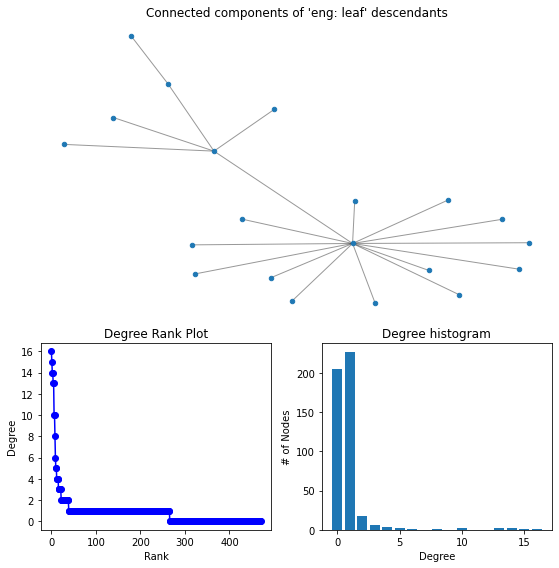

In [19]:
"""
Let's try to plot something, because why not?


import matplotlib.pyplot as plt

highly_connected_node = nodes_by_degree[-1]
# nodes_in_sub = bfs_tree(graph, source="eng: leaf")
nodes_in_sub = nx.descendants(graph, "eng: leaf")
graph_to_plot = graph.subgraph(nodes_in_sub)

nx.draw(graph_to_plot, with_labels=True)

nx.draw_shell(graph_to_plot)
plt.show()

Well that looks like my 3rd grade art work...

Let's try with edges and such

nx.draw_networkx(graph_to_plot, arrows=True, with_labels=True)
nx.draw_shell(graph_to_plot)
plt.show()

Ok time to be lazy and ~~steal~~ borrow from the networkx example drawings

Need to keep it to a smaller graph because it just plots as giant unreadable mess with many nodes


"""

import matplotlib.pyplot as plt
import numpy as np

undirected_graph_to_plot = graph.subgraph(nx.descendants(graph, "eng: leaf")).to_undirected()

degree_sequence = sorted([d for n, d in undirected_graph_to_plot.degree()], reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of node 'eng: leaf' descendants", figsize=(8, 8))
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = undirected_graph_to_plot.subgraph(sorted(nx.connected_components(undirected_graph_to_plot), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of 'eng: leaf' descendants")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()